In [1]:
from pathlib import Path
from pl_models.DEA import DAE_LitModel
import matplotlib.pyplot as plt
import nibabel as nib
import torch
from torchvision import transforms
from BIDS import NII
from BIDS.core.np_utils import np_dice
import numpy as np
from BIDS.core.np_utils import np_map_labels, Label_Map
from sklearn.manifold import TSNE
import torchvision
from dataloader.dataset_factory import get_data_loader, get_dataset
from torch.utils.data import DataLoader
from utils import arguments
import tqdm

opt = arguments.DAE_Option().get_opt(None, None)


dataset = get_dataset(arguments.DataSet_Option,"val")

#part_tr = torch.utils.data.random_split(dataset, [0, len(dataset)-10])[0]
subset_indices = [0,1]
part_tr =  torch.utils.data.Subset(dataset, subset_indices)
#datset = dataset.
val_dataloader = DataLoader(
        part_tr,
        batch_size=2,#opt.batch_size,
        #sampler=sampler,
        # with sampler, use the sample instead of this option
        shuffle=False,# if sampler else shuffle,
        num_workers=16,#opt.num_cpu,
        pin_memory=True,
        #drop_last=drop_last,
        #multiprocessing_context=get_context("fork"),
        persistent_workers=True,
    )
checkpoint_path ="/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_95_old_verse_w_norm/version_3/checkpoints/epoch=16-step=25270_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_232/checkpoints/epoch=283-step=27190_latest.ckpt"# "/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_133/checkpoints/epoch=3-step=310_latest.ckpt"
device = "cuda:0"  # or "cpu" if you want to use CPU
assert Path(checkpoint_path).exists()
model = DAE_LitModel.load_from_checkpoint(checkpoint_path)
model.ema_model.eval()
model.ema_model.to(device)
outputs = np.empty((2, 512))
i = 0
for batch in val_dataloader:
    # print(i)
    
    images = batch['img'].to(device)
 
    output = model.encode(images)
 
    current_outputs = output.detach().cpu().numpy()
    features = np.concatenate((outputs, current_outputs))
    i = i+1
    
    
print(i)
# batch_imgs = next(iter(val_dataloader))
# imgs = batch_imgs['img']  # Extract 'img' from the dictionary
# embs = model.encode(imgs.to(device))  # Ensure the images are on the correct device


# print("Input images: " + str(imgs.shape))
# print("Embeddings: " + str(embs.shape))



/home/martina/.conda/envs/dae_cond/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/media/DATA/martina_ma/cutout/train_3D_95_old_verse_seg_dataset.csv
Model params: 1.27 M


####################################
/tmp/ipykernel_7622/3658903130.py:55: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(current_tx, current_ty, c=color, label=label)
  File "/home/martina/.conda/envs/dae_cond/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/martina/.conda/envs/dae_cond/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/martina/.conda/envs/dae_cond/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/martina/.conda/envs/dae_cond/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in l

IndexError: index 4 is out of bounds for axis 0 with size 4

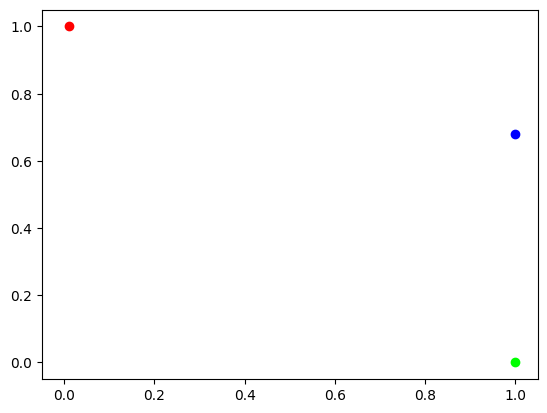

In [3]:
class_colors = {
    0: [255, 255, 255],  # background color
    41: [255, 0, 0],     # color for class 41
    42: [0, 255, 0],     # color for class 42
    43: [0, 0, 255],     # color for class 43
    44: [255, 255, 0],   # color for class 44
    45: [255, 0, 255],   # color for class 45
    46: [0, 255, 255],   # color for class 46
    47: [128, 0, 0],     # color for class 47
    48: [0, 128, 0],     # color for class 48
    49: [0, 0, 128]      # color for class 49
}

tsne = TSNE(n_components=2, perplexity=1).fit_transform(features)
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)

labels = [0,41,42,43,44,45,46,47,48,49]
# create a dictionary for colors_per_class
colors_per_class = {label: class_colors.get(label, [0, 0, 0]) for label in labels}

# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = np.array(colors_per_class[label], dtype=float) / 255
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label)
 
# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot
plt.show()

In [8]:
from pathlib import Path
from pl_models.DEA import DAE_LitModel
import matplotlib.pyplot as plt
import nibabel as nib
import torch
from torchvision import transforms
from BIDS import NII
from BIDS.core.np_utils import np_dice
import numpy as np
from BIDS.core.np_utils import np_map_labels, Label_Map
from sklearn.manifold import TSNE
import torchvision


#3D
def load_nifti(nii):
        
        from_im = nii.get_seg_array()
       #range_print(torch.from_numpy(from_im.astype(float)),41,41)
        #print(from_im[143,95,:])
        from_im = np_map_labels(arr=from_im,label_map={50: 49})
        from_im = from_im.astype(float)
        from_im = map_to_binary(from_im)
        # print(from_im[143,95,143])
        # print("from_im shape:", from_im.shape)
        # print("mapped:",np.unique(from_im))
        from_im = torch.from_numpy(from_im).unsqueeze(0).unsqueeze(0)
        #print("from_im shape:", from_im.shape)
        from_im = from_im.to(torch.float32)
        
        #print("tesnor", from_im.shape)
        return from_im
def map_to_binary(y):
        #y = y.astype(float)
        labelmap = {i: 1 for i in range(41, 50)} #  labelmap = {i: round((i - 40)/9, ndigits=2) for i in range(41, 50)}
        #print(labelmap)
        return np_map_labels(y, labelmap)

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

nii = NII.load(
    "/media/DATA/martina_ma/cutout/verse040/verse040_018_subreg_cropped.nii.gz",
    True,
)
from_im = load_nifti(nii)

checkpoint_path ="/media/DATA/martina_ma/dae/lightning_logs/DAE_3D_binary/version_16/checkpoints/epoch=40-step=9905_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_232/checkpoints/epoch=283-step=27190_latest.ckpt"# "/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_133/checkpoints/epoch=3-step=310_latest.ckpt"
#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_135/checkpoints/epoch=27-step=2775_latest.ckpt"#/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_133/checkpoints/epoch=3-step=310_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_118/checkpoints/epoch=80-step=243_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_116/checkpoints/epoch=81-step=246_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_108/checkpoints/epoch=47-step=144_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_105/checkpoints/epoch=69-step=210_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_63/checkpoints/epoch=79-step=240_latest.ckpt"#"/media/DATA/martina_ma/dae/lightning_logs/DAE_NAKO_256/version_60/checkpoints/epoch=71-step=216_latest.ckpt"#lightning_logs/DAE_NAKO_256/version_26/checkpoints/epoch=404-step=405_latest.ckpt"
device = "cuda:0"  # or "cpu" if you want to use CPU
assert Path(checkpoint_path).exists()
model = DAE_LitModel.load_from_checkpoint(checkpoint_path)
model.ema_model.eval()
model.ema_model.to(device)

#encoder.eval()
#decoder.eval()
noise = torch.randn(1, 1, 144, 144, device=device)

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images = from_im#, labels = iter(test_loader).next()
    images = images.to(device)
    latent = model.encode(images)
    n = model.encode_stochastic(images,latent,T=20)
    latent = latent.cpu()
    print(latent.shape)
    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(1, 512)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = model.render(n, cond=latent,T=20)
    img_recon = img_recon.cpu()

    reconstructed_img = torch.where(img_recon < 0, torch.tensor(0.0), img_recon)
    r = reconstructed_img[0][0].numpy().copy()
    reconstructed_img =np.round(r)#model_map_to_segmentation_map(r)
    nii.set_array_(reconstructed_img).save("NewSampledFrom_verse040_018_ver16_binary_T20.nii.gz")
    # fig, ax = plt.subplots(figsize=(20, 8.5))
    # show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    # plt.show()

Model params: 1.27 M
torch.Size([1, 512])
tensor([ 1.4021e-01, -1.6876e-01,  2.8362e-01, -1.6302e-02, -1.0010e-01,
         4.4390e-01,  5.0438e-02, -1.4000e-03,  7.5288e-02, -8.0033e-02,
        -6.0241e-03, -1.4994e-01,  4.8438e-02,  2.6762e-01, -1.9844e-01,
         6.2865e-02, -5.9521e-01,  1.9800e-01,  8.2682e-03, -2.8929e-01,
         6.7777e-01,  2.8428e-01, -5.7899e-02,  9.7882e-02, -4.2737e-03,
         3.2067e-01,  2.6300e-01,  2.6677e-01,  3.5737e-01,  4.0709e-01,
         3.9705e-01,  2.7432e-02, -1.4441e-01,  5.6260e-01,  2.1019e-01,
         5.8829e-01,  3.6127e-01,  2.5707e-01, -6.6680e-02,  2.4313e-01,
        -1.6112e-01, -5.1418e-01,  8.7135e-02,  2.7604e-01, -2.5527e-01,
         4.5784e-02, -2.3765e-01, -2.5463e-01,  2.5262e-01,  6.1959e-02,
         1.4524e-01,  3.3865e-01, -1.3991e-01, -3.3206e-01,  2.7449e-02,
        -1.8164e-02,  4.4237e-01,  2.6772e-01,  4.8917e-02,  4.6736e-02,
         5.0564e-02,  2.4482e-01, -2.2614e-01, -2.9774e-02, -1.4594e-01,
        -

: 